In [ ]:
# ! pip3 install tensorflow
# ! pip3 install keras
# ! pip3 install matplotlib
# ! pip3 install pydot
# ! pip install graphviz

In [1]:
import tensorflow
import keras
import matplotlib 
import pydot
import graphviz
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow.compat.v1 as tf 
import splitfolders

In [ ]:
data_folder = 'C:/Users/anato/Desktop/Università/ML/archive/df'

In [ ]:
# to skip once you have the output folder ready 
splitfolders.ratio('/Users/anato/Desktop/Università/ML/archive/df', output = "output",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [2]:
train = 'output\train'
val = 'output\val'
test = 'output\test'

In [3]:
root_path = 'output'
categories = ['train', 'val','test']
classes = ['muffin', 'chihuahua']

In [4]:
def removal_corrupted_files(category):
    num_skipped = 0
    for class_name in classes:
        folder = os.path.join(root_path, category, class_name)
        if not os.path.exists(folder):
            print("Directory does not exist, skipping:", folder)
            continue
            
        for fname in os.listdir(folder):
            fpath = os.path.join(folder, fname)
            try:
                with open(fpath, "rb") as fobj:
                    is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
                    
            except IOError as e:
                print("Error opening file:", e)
                continue
                
            if not is_jfif or os.stat(fpath).st_size == 0:
                num_skipped += 1
                # Delete corrupted or empty image
                print(f"Removing corrupted or empty image: {fpath}")
                os.remove(fpath)

    print(f"Deleted {num_skipped} images from {category} category.")
    return os.path.join(root_path, category)  # Return the path to the cleaned category


In [5]:
train_clean = removal_corrupted_files('train')
val_clean = removal_corrupted_files('val')
test_clean = removal_corrupted_files('test')

Deleted 0 images from train category.
Error opening file: [Errno 13] Permission denied: 'output\\val\\chihuahua\\.ipynb_checkpoints'
Deleted 0 images from val category.
Deleted 0 images from test category.


In [ ]:
train_clean

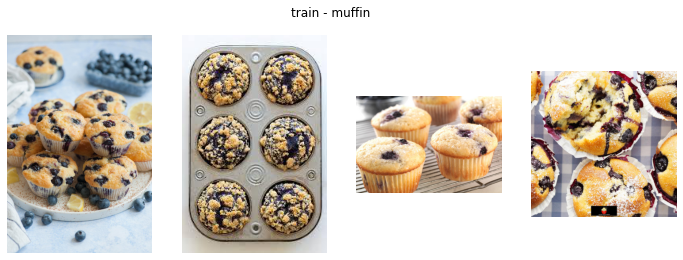

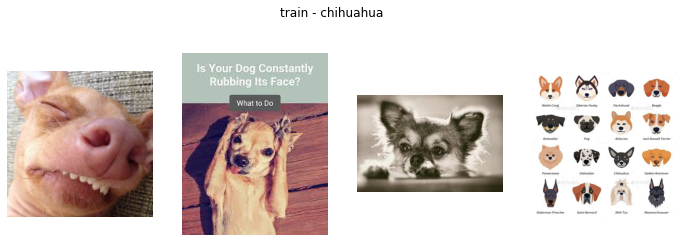

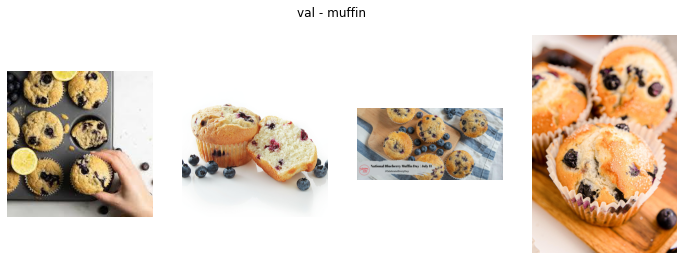

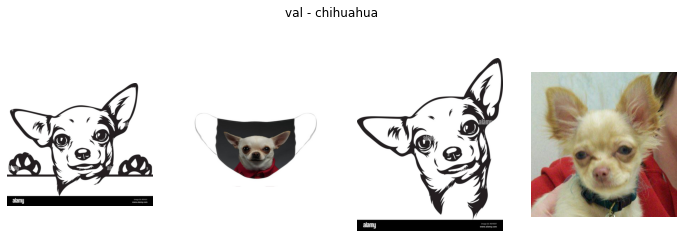

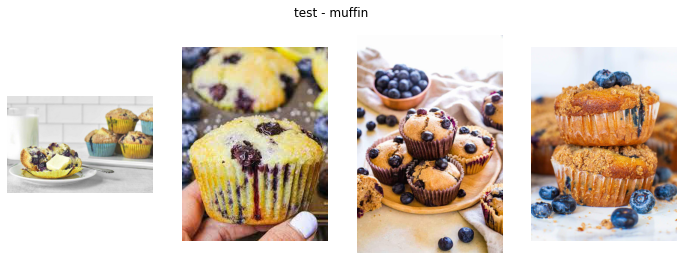

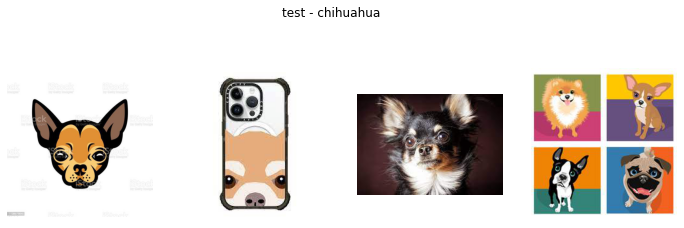

In [6]:
num_images_to_display = 4

# Function to load images from the specified directory
def load_images_from_folder(folder, num_images):
    images = []
    for filename in os.listdir(folder):
        if len(images) == num_images:
            break
        img_path = os.path.join(folder, filename)
        try:
            with Image.open(img_path) as img:
                images.append(img.copy())
        except (IOError, FileNotFoundError):
            continue
    return images

# Function to display images
def display_images(images, title):
    plt.figure(figsize=(12, 4))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Iterate over categories and classes and display images
for category in categories:
    for class_name in classes:
        folder = os.path.join(root_path, category, class_name)
        images = load_images_from_folder(folder, num_images_to_display)
        display_images(images, f"{category} - {class_name}")

In [7]:
# Function for preprocessing the images 
def preprocessing_step(folder, IMG_SIZE):
    categories = ['muffin', 'chihuahua']
    data = []

    for category in categories:
        path = os.path.join(folder, category)
        if not os.path.exists(path):
            print(f"Category path does not exist: {path}")
            continue
            
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file) # get the full image path
            label = categories.index(category)  # get the label (index in categories list)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Convert image to RGB
                    img = img.resize((IMG_SIZE, IMG_SIZE))  # Resize the image
                    img_array = np.array(img)  # Convert to NumPy array
                    data.append([img_array, label])  # Append image data and label to the data list
            except Exception as e:
                print(f"Could not process image {img_path}: {e}")  # Output an error message if the image cannot be processed

    return data

In [8]:
train = preprocessing_step(train_clean, 90)
test = preprocessing_step(test_clean, 90)
val = preprocessing_step(val_clean, 90)

Could not process image output\val\chihuahua\.ipynb_checkpoints: [Errno 13] Permission denied: 'output\\val\\chihuahua\\.ipynb_checkpoints'


In [ ]:
# dataset
n_muffin = len(os.listdir('/Users/anato/Desktop/Università/ML/archive/df/muffin'))
n_chihuahua = len(os.listdir('/Users/anato/Desktop/Università/ML/archive/df/chihuahua'))
total = n_muffin + n_chihuahua

In [ ]:
print("Muffin photos :" +str(n_muffin))
print("Chihuahua photos:" +str(n_chihuahua))

# checking for class imbalance
print('Examples:\n    Total: {}\n    Chihuahua: {} ({:.2f}% of total)\n'.format(
    total, n_chihuahua, (100 * n_chihuahua / (n_muffin + n_chihuahua))))

In [9]:
X = []  # Temporary list to hold features
y = []  # Temporary list to hold labels

for features, label in train:
    X.append(features)
    y.append(label)

# Convert to numpy arrays

X_train = np.array(X)
y_train = np.array(y)
# Rescaling
X_train = X_train / 255

In [10]:
X = []  # Temporary list to hold features
y = []  # Temporary list to hold labels

for features, label in test:
    X.append(features)
    y.append(label)

# Convert to numpy arrays
X_test = np.array(X)
y_test = np.array(y)
# Rescaling
X_test = X_test / 255

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4733, 90, 90, 3)
(4733,)
(594, 90, 90, 3)
(594,)


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

## Model 1: Baseline model + variations
- Model 1.1 and 1.2 only include different layers
- Model 1.3 and 1.4 add a drop out layer to decrease overfitting and 1.4 adds Early Stopping \
The models are result of a selection process based on validation loss and accuracy.

In [13]:
np.random.seed(5)
#np.random.seed(25)
#np.random.seed(125)
# np.random.seed(625)
# np.random.seed(3125)

In [14]:
# Start by adding early stopping to all the models
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', # monitors accuracy
    patience=9, # interrupt after 10 epochs 
    verbose=1,
    restore_best_weights=True # ripristina i pesi migliori al termine dell'early stopping
)

In [ ]:
def get_callbacks(patience):
        return [
            EarlyStopping(
                monitor='val_loss',
                patience=patience,
                verbose=1,
                restore_best_weights=True
            )
        ]

In [15]:
# Model 1: 1 CovNet followed by a dense layer
model1 = Sequential()

#First convolutional layer with 32 filters
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))

#Flatten layer
model1.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors

#Fully Connected Layers
model1.add(Dense(32, activation='relu')) 
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid')) 

#con 62,32 va in overfitting dopo 3 epoche
# con 32 va in overfitting dopo la sesta

In [16]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
history1 = model1.fit(X_train, y_train, epochs=50, validation_split = 0.2, callbacks=get_callbacks(9))  

Epoch 1/50
119/119 [==============================] - 15s 121ms/step - loss: 0.7709 - accuracy: 0.5716 - val_loss: 0.7166 - val_accuracy: 0.0000e+00
Epoch 2/50
119/119 [==============================] - 14s 117ms/step - loss: 0.6884 - accuracy: 0.5742 - val_loss: 0.7451 - val_accuracy: 0.0000e+00
Epoch 3/50
119/119 [==============================] - 14s 115ms/step - loss: 0.6860 - accuracy: 0.5742 - val_loss: 0.7676 - val_accuracy: 0.0000e+00
Epoch 4/50
119/119 [==============================] - 14s 116ms/step - loss: 0.6844 - accuracy: 0.5742 - val_loss: 0.7888 - val_accuracy: 0.0000e+00
Epoch 5/50
119/119 [==============================] - 14s 116ms/step - loss: 0.6834 - accuracy: 0.5742 - val_loss: 0.8037 - val_accuracy: 0.0000e+00
Epoch 6/50
119/119 [==============================] - 14s 116ms/step - loss: 0.6828 - accuracy: 0.5742 - val_loss: 0.8162 - val_accuracy: 0.0000e+00
Epoch 7/50
119/119 [==============================] - 14s 116ms/step - loss: 0.6825 - accuracy: 0.5742 - v

Text(0.5, 1.0, 'Model 1: Training vs Validation Accuracy')

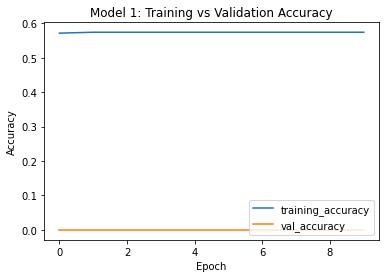

In [18]:
plt.plot(history1.history['accuracy'], label='training_accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Model 1: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 1: Training vs Validation Loss')

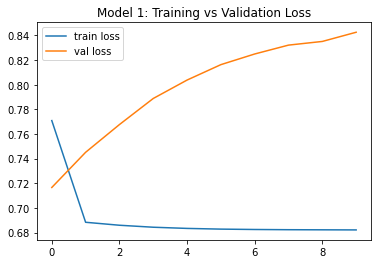

In [19]:
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 1: Training vs Validation Loss")

In [20]:
# Model 1.2 : 2 CovNets followed by a dense layer
model1_2 = Sequential()

#First convolutional layer with 32 filters
model1_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)))
model1_2.add(MaxPooling2D((2, 2)))
model1_2.add(Dropout(0.5))

#Second convolutional layer with 64 filters
model1_2.add(Conv2D(64, (3, 3), activation='relu')) 
model1_2.add(MaxPooling2D((2, 2)))
model1_2.add(Dropout(0.5))

#Flatten layer
model1_2.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors

#Fully Connected Layers
#model2.add(Dense(64, activation='relu'))
model1_2.add(Dense(32, activation='relu'))
model1_2.add(Dropout(0.5))

model1_2.add(Dense(1, activation='sigmoid'))

#con 64 e 16 va in overfitting dopo 3 epoche, nonostante il dropout

In [21]:
model1_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history1_2 = model1_2.fit(X_train, y_train, epochs=50, validation_split = 0.2, callbacks=get_callbacks(9))  

Epoch 1/50
119/119 [==============================] - 27s 218ms/step - loss: 0.6939 - accuracy: 0.5700 - val_loss: 0.8006 - val_accuracy: 0.0000e+00
Epoch 2/50
119/119 [==============================] - 24s 204ms/step - loss: 0.5864 - accuracy: 0.6838 - val_loss: 0.8175 - val_accuracy: 0.6030
Epoch 3/50
119/119 [==============================] - 24s 198ms/step - loss: 0.5565 - accuracy: 0.7504 - val_loss: 0.7788 - val_accuracy: 0.6906
Epoch 4/50
119/119 [==============================] - 20s 171ms/step - loss: 0.5120 - accuracy: 0.7861 - val_loss: 0.6291 - val_accuracy: 0.9229
Epoch 5/50
119/119 [==============================] - 22s 187ms/step - loss: 0.4921 - accuracy: 0.7998 - val_loss: 0.8570 - val_accuracy: 0.6463
Epoch 6/50
119/119 [==============================] - 21s 173ms/step - loss: 0.4727 - accuracy: 0.8093 - val_loss: 0.8954 - val_accuracy: 0.6294
Epoch 7/50
119/119 [==============================] - 20s 171ms/step - loss: 0.4723 - accuracy: 0.8077 - val_loss: 0.7465 - va

Text(0.5, 1.0, 'Model 1.2: Training vs Validation Accuracy')

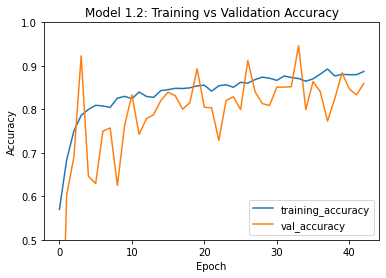

In [23]:
plt.plot(history1_2.history['accuracy'], label='training_accuracy')
plt.plot(history1_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 1.2: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 1.2: Training vs Validation Loss')

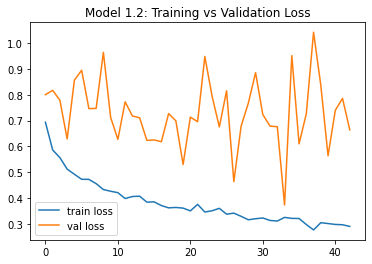

In [24]:
plt.plot(history1_2.history['loss'], label='train loss')
plt.plot(history1_2.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 1.2: Training vs Validation Loss")

In [25]:
# Model 1.3 : Add a dropout layer to each convolutional layer and to the dense layer
model1_3 = Sequential()

# First convolutional layer with 32 filters
model1_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)))
model1_3.add(MaxPooling2D((2, 2)))
model1_3.add(Dropout(0.5))

# Second convolutional layer with 64 filters
model1_3.add(Conv2D(64, (3, 3), activation='relu'))
model1_3.add(MaxPooling2D((2, 2)))
model1_3.add(Dropout(0.5))

# Add a flatten layer 
model1_3.add(Flatten())

# Dense layer and drop-out layer for regularization
#model1_3.add(Dense(64, activation='relu')) 
#model1_3.add(Dense(32, activation='relu')) # val_loss: 0.3395 - val_accuracy: 0.8617
model1_3.add(Dense(32, activation='relu')) #val_loss: 0.3183 - val_accuracy: 0.8765
model1_3.add(Dropout(0.5))
model1_3.add(Dense(1, activation='sigmoid'))

In [26]:
model1_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
history1_3 = model1_3.fit(X_train, y_train, epochs=50, validation_split = 0.2, callbacks=get_callbacks(9)

Epoch 1/50
119/119 [==============================] - 20s 164ms/step - loss: 0.7320 - accuracy: 0.5584 - val_loss: 0.7172 - val_accuracy: 0.0000e+00
Epoch 2/50
119/119 [==============================] - 19s 163ms/step - loss: 0.6883 - accuracy: 0.5742 - val_loss: 0.7469 - val_accuracy: 0.0000e+00
Epoch 3/50
119/119 [==============================] - 19s 159ms/step - loss: 0.6857 - accuracy: 0.5742 - val_loss: 0.7720 - val_accuracy: 0.0000e+00
Epoch 4/50
119/119 [==============================] - 19s 159ms/step - loss: 0.6841 - accuracy: 0.5742 - val_loss: 0.7928 - val_accuracy: 0.0000e+00
Epoch 5/50
119/119 [==============================] - 19s 160ms/step - loss: 0.6832 - accuracy: 0.5742 - val_loss: 0.8074 - val_accuracy: 0.0000e+00
Epoch 6/50
119/119 [==============================] - 19s 159ms/step - loss: 0.6827 - accuracy: 0.5742 - val_loss: 0.8214 - val_accuracy: 0.0000e+00
Epoch 7/50
119/119 [==============================] - 19s 159ms/step - loss: 0.6824 - accuracy: 0.5742 - v

Text(0.5, 1.0, 'Model 1.3: Training vs Validation Accuracy')

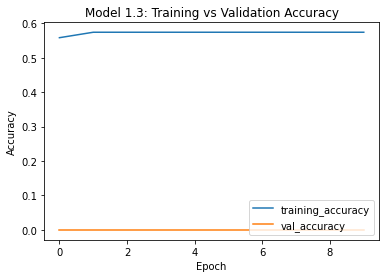

In [28]:
plt.plot(history1_3.history['accuracy'], label='training_accuracy')
plt.plot(history1_3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 1.3: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 1.3: Training vs Validation Loss')

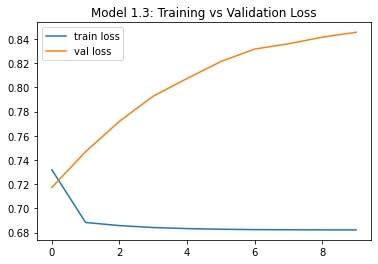

In [29]:
plt.plot(history1_3.history['loss'], label='train loss')
plt.plot(history1_3.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 1.3: Training vs Validation Loss")

## Adding data augmentation layer

In [31]:
train_datagen = ImageDataGenerator(
        rescale=1./255)
        #horizontal_flip=True)        

test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
# The models are trained on a larger version of the previous dataset, but has never seen the validation data
train_generator = train_datagen.flow_from_directory(
        'output/train',
        target_size=(90, 90),
        batch_size=32,
        class_mode='binary')

val_generator = test_datagen.flow_from_directory(
        'output/val', 
        target_size=(90, 90),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        'output/test', 
        target_size=(90, 90),
        batch_size=32,
        class_mode='binary')

Found 4733 images belonging to 2 classes.
Found 589 images belonging to 2 classes.
Found 594 images belonging to 2 classes.


In [33]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [34]:
# Model 1.4 : Add a third layer and a dropout layer to each convolutional layer, + add a data augmentation layer
model4 = Sequential()

# Add a data augmentation layer 
model4.add(data_augmentation)

# First convolutional layer with 32 filters
model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.5))

# Second convolutional layer with 64 filters
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.5))

#Third convolutional layer with 128 filters
model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.5))

# Add a filter layer 
model4.add(Flatten())

# Dense layer and drop-out layer for regularization
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))

In [35]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
history4 = model4.fit(train_generator, validation_data = val_generator, epochs=60, callbacks=get_callbacks(7))

Epoch 1/60
148/148 [==============================] - 74s 487ms/step - loss: 0.6962 - accuracy: 0.5269 - val_loss: 0.6926 - val_accuracy: 0.5399
Epoch 2/60
148/148 [==============================] - 68s 457ms/step - loss: 0.6830 - accuracy: 0.5453 - val_loss: 0.6064 - val_accuracy: 0.7793
Epoch 3/60
148/148 [==============================] - 68s 460ms/step - loss: 0.6001 - accuracy: 0.6535 - val_loss: 0.5468 - val_accuracy: 0.7640
Epoch 4/60
148/148 [==============================] - 67s 454ms/step - loss: 0.5330 - accuracy: 0.7357 - val_loss: 0.5452 - val_accuracy: 0.6672
Epoch 5/60
148/148 [==============================] - 67s 452ms/step - loss: 0.5016 - accuracy: 0.7501 - val_loss: 0.4950 - val_accuracy: 0.7470
Epoch 6/60
148/148 [==============================] - 78s 526ms/step - loss: 0.4769 - accuracy: 0.7710 - val_loss: 0.4451 - val_accuracy: 0.7963
Epoch 7/60
148/148 [==============================] - 76s 514ms/step - loss: 0.4564 - accuracy: 0.7801 - val_loss: 0.4134 - val_ac

Text(0.5, 1.0, 'Model 1.4: Training vs Validation Accuracy')

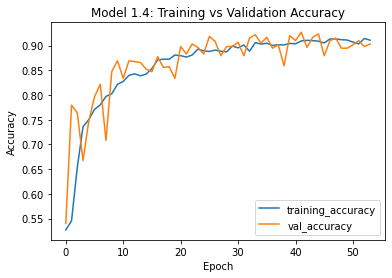

In [38]:
plt.plot(history4.history['accuracy'], label='training_accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 1.4: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 4: Training vs Validation Loss')

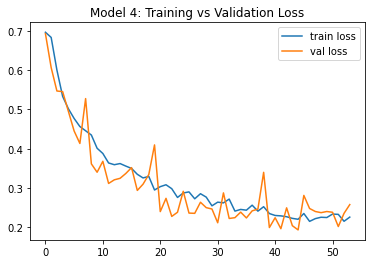

In [39]:
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 4: Training vs Validation Loss")

In [40]:
from keras.layers import BatchNormalization

model4_1 = Sequential()

# Adding a data augmentation layer
model4_1.add(data_augmentation)
# First convolutional layer with 32 filters
model4_1.add(Conv2D(32, (3, 3), input_shape=(90, 90, 3)))
model4_1.add(BatchNormalization())
model4_1.add(Activation('relu'))
model4_1.add(MaxPooling2D((2, 2)))
#model1_4_1.add(Dropout(0.5))

# Second convolutional layer with 64 filters
model4_1.add(Conv2D(64, (3, 3)))
model4_1.add(BatchNormalization())
model4_1.add(Activation('relu'))
model4_1.add(MaxPooling2D((2, 2)))
#model1_4_1.add(Dropout(0.5))

# Flatten the output of the convolutional layers
model4_1.add(Flatten())

# Dense layer with 32 neurons
model4_1.add(Dense(32))
model4_1.add(BatchNormalization())
model4_1.add(Activation('relu'))

# Output layer with single neuron and sigmoid activation for binary classification
model4_1.add(Dense(1, activation='sigmoid'))


In [41]:
# Compile the model
model4_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit model (use the previously defined early_stopping and tensorboard callbacks)
history4_1 = model4_1.fit(train_generator, validation_data = val_generator, epochs=60, callbacks=get_callbacks(7))

Epoch 1/60
148/148 [==============================] - 120s 790ms/step - loss: 0.4155 - accuracy: 0.8244 - val_loss: 2.1651 - val_accuracy: 0.5399
Epoch 2/60
148/148 [==============================] - 120s 810ms/step - loss: 0.3267 - accuracy: 0.8690 - val_loss: 2.1713 - val_accuracy: 0.5399
Epoch 3/60
148/148 [==============================] - 112s 756ms/step - loss: 0.2870 - accuracy: 0.8796 - val_loss: 0.4151 - val_accuracy: 0.7980
Epoch 4/60
148/148 [==============================] - 86s 582ms/step - loss: 0.2672 - accuracy: 0.8910 - val_loss: 0.3474 - val_accuracy: 0.8438
Epoch 5/60
148/148 [==============================] - 83s 559ms/step - loss: 0.2609 - accuracy: 0.8882 - val_loss: 0.7559 - val_accuracy: 0.7199
Epoch 6/60
148/148 [==============================] - 68s 460ms/step - loss: 0.2426 - accuracy: 0.8973 - val_loss: 0.8130 - val_accuracy: 0.7216
Epoch 7/60
148/148 [==============================] - 65s 443ms/step - loss: 0.2216 - accuracy: 0.9104 - val_loss: 0.9515 - val

Text(0.5, 1.0, 'Model 4.1: Training vs Validation Accuracy')

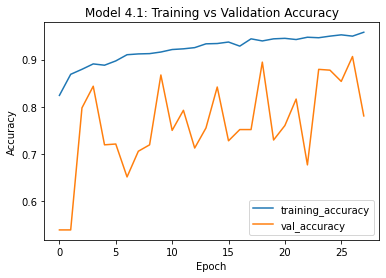

In [42]:
plt.plot(history4_1.history['accuracy'], label='training_accuracy')
plt.plot(history4_1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 4.1: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 4.1: Training vs Validation Loss')

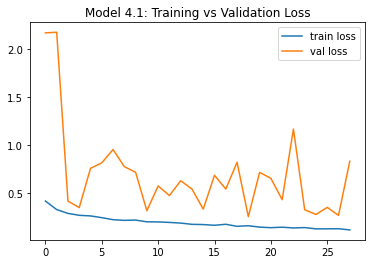

In [43]:
plt.plot(history4_1.history['loss'], label='train loss')
plt.plot(history4_1.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 4.1: Training vs Validation Loss")

In [44]:
# Model 1.5 : Add a fourth layer and a dropout layer to each convolutional layer
model5 = Sequential()

# Adding a data augmentation layer
model5.add(data_augmentation)

# First convolutional layer with 32 filters
model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.5))

# Second convolutional layer with 64 filters
model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.5))

#Third convolutional layer with 128 filters
model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.5))

# Fourth convolutional layer with 256 filters
model5.add(Conv2D(256, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.5))

# Add a filter layer 
model5.add(Flatten())

# Dense layer and drop-out layer for regularization
model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(1, activation='sigmoid'))

In [45]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history5 = model5.fit(train_generator, validation_data = val_generator, epochs=60, callbacks=get_callbacks(9))

Epoch 1/60
148/148 [==============================] - 69s 461ms/step - loss: 0.6908 - accuracy: 0.5297 - val_loss: 0.6865 - val_accuracy: 0.6520
Epoch 2/60
148/148 [==============================] - 67s 453ms/step - loss: 0.6208 - accuracy: 0.6774 - val_loss: 0.6267 - val_accuracy: 0.5688
Epoch 3/60
148/148 [==============================] - 68s 460ms/step - loss: 0.5514 - accuracy: 0.7572 - val_loss: 0.4965 - val_accuracy: 0.8200
Epoch 4/60
148/148 [==============================] - 71s 479ms/step - loss: 0.4797 - accuracy: 0.8044 - val_loss: 0.4789 - val_accuracy: 0.7674
Epoch 5/60
148/148 [==============================] - 67s 450ms/step - loss: 0.4290 - accuracy: 0.8278 - val_loss: 0.4284 - val_accuracy: 0.8285
Epoch 6/60
148/148 [==============================] - 66s 447ms/step - loss: 0.4114 - accuracy: 0.8377 - val_loss: 0.3932 - val_accuracy: 0.8387
Epoch 7/60
148/148 [==============================] - 67s 454ms/step - loss: 0.4061 - accuracy: 0.8310 - val_loss: 0.5697 - val_ac

Text(0.5, 1.0, 'Model 5: Training vs Validation Accuracy')

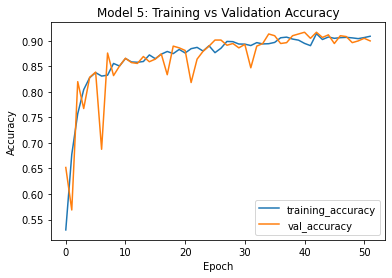

In [46]:
plt.plot(history5.history['accuracy'], label='training_accuracy')
plt.plot(history5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
 #plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 5: Training vs Validation Accuracy")

Text(0.5, 1.0, 'Model 5: Training vs Validation Loss')

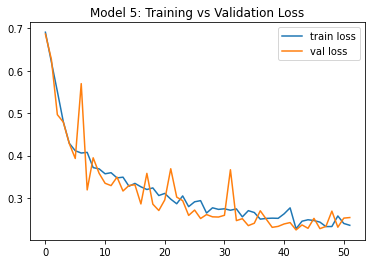

In [47]:
plt.plot(history5.history['loss'], label='train loss')
plt.plot(history5.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model 5: Training vs Validation Loss")

## Hyperparameter tuning

In [48]:
from kerastuner import HyperModel
from tensorflow import keras
import tensorflow.keras.layers
from tensorflow.keras.models import Sequential

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        model = Sequential()
        
        # First convolutional layer with hp.Int for optimizing the number of filters
        model.add(Conv2D(hp.Int('filters_1', min_value=16, max_value=64, step=16),
                         kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.7, step=0.1)))

        # Second convolutional layer with hp.Int for optimizing the number of filters
        model.add(Conv2D(hp.Int('filters_2', min_value=32, max_value=128, step=32), 
                         kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.3, max_value=0.7, step=0.1)))

        # Third convolutional layer with hp.Int for optimizing the number of filters
        model.add(Conv2D(hp.Int('filters_3', min_value=64, max_value=256, step=64),
                         kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.3, max_value=0.7, step=0.1)))

        # Flatten layer to convert the 2D outputs to 1D
        model.add(Flatten())

        # Dense layer with hp.Int for optimizing the number of units
        model.add(Dense(hp.Int('units_1', min_value=16, max_value=128, step=16), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.3, max_value=0.7, step=0.1)))

        # Output layer
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile the model
        model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        return model

C:\Users\anato\AppData\Local\Temp/ipykernel_22872/1241978599.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [49]:
from kerastuner.tuners import BayesianOptimization

tuner = BayesianOptimization(
    hypermodel=MyHyperModel(input_shape=(90, 90, 3)),
    objective='val_loss',   # Puoi scegliere un'altra metrica come 'val_loss'
    max_trials=20,              # Numero totale di tentativi (set di iperparametri)
    num_initial_points=5,       # Numero di punti per iniziare la ricerca bayesiana
    directory='my_dir',
    project_name='keras_bayesian_opt'
)

Reloading Tuner from my_dir\keras_bayesian_opt\tuner0.json


In [62]:
tuner.search(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=get_callbacks(5)
)

Trial 20 Complete [01h 05m 45s]
val_loss: 0.16911712288856506

Best val_loss So Far: 0.16563107073307037
Total elapsed time: 18h 31m 36s


In [65]:
best_hps = tuner.get_best_hyperparameters(num_trials=20)[0]

In [67]:
best_hps.values

{'filters_1': 48,
 'dropout_1': 0.4,
 'filters_2': 96,
 'dropout_2': 0.6000000000000001,
 'filters_3': 256,
 'dropout_3': 0.5,
 'units_1': 32,
 'dropout_4': 0.5,
 'learning_rate': 0.00033418539376346706}